In Part 2 of the project, we will specify and fit a linear model to a few features of the housing data to predict housing prices. Next, we will analyze the error of the model and brainstorm ways to improve the model's performance. Finally, we'll delve deeper into the implications of predictive modeling within the Cook County Assessor's Office (CCAO) case study, especially because statistical modeling is how the CCAO valuates properties. Given the history of racial discrimination in housing policy and property taxation in Cook County, we consider the impacts of our modeling results.

In [1]:
import hashlib

import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

from ds100_utils import run_linear_regression_test

def get_hash(num):
    return hashlib.md5(str(num).encode()).hexdigest()

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

Let's load the training and test data.

This dataset is split into a training/validation set, and a test set. Importantly, the test set does not contain values for our target variable, Sale Price. We will train a model on the training and validation sets and then use this model to predict the Sale Prices of the test set. In the cell below, we load the training and validation sets into the DataFrame `tr_val_data` and the test set into the DataFrame `test_data`.

In [2]:
tr_val_data = pd.read_csv("data/cook_county_train_val.csv", index_col='Unnamed: 0')
test_data = pd.read_csv("data/cook_county_contest_test.csv", index_col='Unnamed: 0')

In [3]:
len(test_data)

55311

As a good sanity check, we should at least verify that the data shape matches the description.

In [4]:
# 204792 observations and 62 features in training data
assert tr_val_data.shape == (204792, 62)
# 55311 observations and 61 features in test data
assert test_data.shape == (55311, 61)
# Sale Price is provided in the training/validation data
assert 'Sale Price' in tr_val_data.columns.values
# Sale Price is hidden in the test data
assert 'Sale Price' not in test_data.columns.values

Data available to us in the Cook County dataset:

In [5]:
tr_val_data.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

## The CCAO Dataset

We'll work with the dataset from the Cook County Assessor's Office (CCAO) in Illinois. This government institution determines property taxes across most of Chicago's metropolitan areas and nearby suburbs. In the United States, all property owners must pay property taxes, which are then used to fund public services, including education, road maintenance, and sanitation. These property tax assessments are based on property values estimated using statistical models considering multiple factors, such as real estate value and construction cost.

This system, however, is not without flaws. In late 2017, a lawsuit was filed against the office of Cook County Assessor Joseph Berrios for producing "[racially discriminatory assessments and taxes](https://www.chicagotribune.com/politics/ct-cook-county-board-assessor-berrios-met-20170718-story.html)." The lawsuit included claims that the assessor's office undervalued high-priced homes and overvalued low-priced homes, creating a visible divide along racial lines: Wealthy homeowners, who were typically white, paid less in property taxes, whereas [working-class, non-white homeowners paid more](https://www.chicagotribune.com/news/breaking/ct-cook-county-assessor-berrios-sued-met-20171214-story.html).

The Chicago Tribune's four-part series, "[The Tax Divide](https://www.chicagotribune.com/investigations/ct-tax-divide-investigation-20180425-storygallery.html)", delves into how this was uncovered: After "compiling and analyzing more than 100 million property tax records from the years 2003 through 2015, along with thousands of pages of documents, then vetting the findings with top experts in the field," they discovered that "residential assessments had been so far off the mark for so many years." You can read more about their investigation  [in this news article](https://apps.chicagotribune.com/news/watchdog/cook-county-property-tax-divide/assessments.html).

The central problems with the earlier property tax system in Cook County as reported by the Chicago Tribune was that the earlier property tax system overvalued homes of people living in lower income neighborhoods and undervalued homes of people living in higher income neighborhoods. Thus, people with lower incomes were disproportionately burdened by property taxes that didn't match the value of their homes.

The primary causes of these problems was the appeal system that enabled people from wealthier neighborhoods to get their homes reassessed (if they felt it was overassessed), but was unfair to those with lower incomes who could not afford a tax lawyer to help them appeal. Thus, homeowners who were able to afford appealing were able to get their homes reassessed, leading to the property tax system that placed an unfair tax burden onto lower income citizens (who could not afford getting their houses reassessed).  

Another cause of these problems was that the assessor's office dismissed the need for updated assessment models, insisting that the appeal system was put in place to account for the assessment model's errors. However, this disregards that fact that not everyone in Cook Country had the equal ability to appeal, as only those who could afford it (those living in more expensive neighborhoods) could hire a tax lawyer to get their home reassessed. 

Making sure there aren't any duplicate rows (considering it a data entry error as each row should represent a unique sale):

In [6]:
# .duplicated is true for all duplicates that occur 
    # after the first occurance of a row. but we only want unique rows
# so filter using .duplicated, then count all unique sale price values
# which will effectively count a duplicate only once
# to compute the rows to remove, take all duplicates 
        # minus number of unique ones we want to keep
    
count_duplicate_properties = tr_val_data[tr_val_data.duplicated()] \
                            ['Sale Price'].nunique()
count_duplicate_rows_to_remove = sum(tr_val_data.duplicated(keep=False))  \
                                    - count_duplicate_properties

print("There are ", count_duplicate_properties, "unique property sales with exact duplicates.")
print("There are ", count_duplicate_rows_to_remove, "a total of duplicate rows that we'll need to remove when we write our cleaning function below.")

There are  5 unique property sales with exact duplicates.
There are  13 a total of duplicate rows that we'll need to remove when we write our cleaning function below.


Next, we will look for any other unusual outliers in the data that we will want to remove as well.

Looking for missing or unusual outliers in the `Sale Prince` field:

In [7]:
# total number of rows is 204792 given by shape
# total number of sale prices with non null entries given by count is also 204792
# indicating no null sale price entries
print("total entries in sale price column: ", str(tr_val_data['Sale Price'].count()))

# the number of rows where the sale price is negative or equal to 0 is 0
print("number of zero/negative entries: ", str(tr_val_data[ \
                            tr_val_data['Sale Price'] <= 0].shape[0]))

print("number of N/A entries: ", sum(tr_val_data['Sale Price'] == None))
# thus, sale price does NOT have any missing, N/A, negative, or 0 values for the data.

# i considered visualizing sale price as a box plot, 
#  then seeing in any points where outside the upper whisker (75 perc + 1.5IQR)
IQR = np.percentile(tr_val_data['Sale Price'], 75) - \
                np.percentile(tr_val_data['Sale Price'], 25)
upper_whisker = np.percentile(tr_val_data['Sale Price'], 75) + 1.5*IQR
print("upper whisker: " ,str(upper_whisker))
print("count of those above upper whisker: ", str(tr_val_data[ \
    tr_val_data['Sale Price'] > upper_whisker].shape[0]))

# i considered visualizing sale price as a box plot, 
#    then seeing in any points where outside the upper whisker (725 perc + 1.5IQR)
lower_whisker = np.percentile(tr_val_data['Sale Price'], 25) - 1.5*IQR
print("lower whisker: " , str(lower_whisker))
print("count of number of 1s: ", str(sum(tr_val_data['Sale Price'] == 1)))
      
# also mention that we see unproportional number of 1s in part 1 of the project
# your code exploring Sale Price above this line

total entries in sale price column:  204792
number of zero/negative entries:  0
number of N/A entries:  0
upper whisker:  712200.0
count of those above upper whisker:  12229
lower whisker:  -355000.0
count of number of 1s:  35546


Pure Market Filter: there are quite a few small values and very large values for the Sale Price of a home that don't make sense. We can use the indicator feature already available in the dataset to help filter out any sale transactions that aren't considered "Pure Market Transactions", as shown below:

In [8]:
max_Sale_Price_filtered = tr_val_data[tr_val_data['Pure Market Filter'] == 1]['Sale Price'].max()

min_Sale_Price_filtered = tr_val_data[tr_val_data['Pure Market Filter'] == 1]['Sale Price'].min()

print("When considering only pure market sales, the max Sale Price of properties in the data is $", max_Sale_Price_filtered)
print("and the min Sale Price is $", min_Sale_Price_filtered)

When considering only pure market sales, the max Sale Price of properties in the data is $ 8490078
and the min Sale Price is $ 10003


The `clean_data` function that takes in a dataframe of property sales `data` and cleans the data as follows:
 - Removes duplicate rows (for example, instead of 3 rows of duplicate data for a unique property sale, we would only keep 1 row with that information),
 - Filters out outliers in Sale Price by only keeping rows with "Pure Market Filter" = 1

In [9]:
def clean_data(data):

    '''
    Cleans the data DataFrame by removing duplicate rows and removing rows with 'Pure Market Filter = 1'

    Args:
        data (DataFrame):  DataFrame to clean
        
    Return:
        Cleaned DataFrame
    '''
    
    da = data.copy()

    da = da.drop_duplicates()
    da = da[da['Pure Market Filter'] == 1]
    # Do NOT reset the index of the cleaned data.
    
    return da

## Cross Validation

We are going to create and compare models to predict the Sale Price of properties in Cook County.  

If we used all the available data to fit and compare our models, we would not have a way to estimate model performance on **unseen data** such as the test set in `cook_county_contest_test.csv`.

We'll start by using Simple Cross Validation to fit and evaluate our models.  This involves taking the `tr_val_clean` data and actually splitting it into a training and validation set.  

We will use the training set to fit each model's parameters and the validation set to evaluate how well each model will likely perform on unseen data drawn from the same distribution. 

In [10]:
def train_val_split(data):
    """ 
    Takes in a DataFrame `data` and splits it into two smaller DataFrames 
    named `validation` and `train` where validation is the first 20% of the rows and train 
    is the last 80% of the rows, respectively. 
    If the the first 20% of the data is not an exact integer, round down to the nearest integer.
    Do not shuffle or re-index the data DataFrame.  
    """
    da = data.copy()
    
    # number of the first 20% of rows as an int rounded down
    twenty_percent_row_count = int(0.2*da.shape[0])
    
    
    # select the first 20% for validation, then remining 80% for training
    validation = da.iloc[:twenty_percent_row_count]
    train = da.iloc[twenty_percent_row_count:]
   
    return train, validation



# To randomize the validation and training sets, we will shuffle the data once before 
# running it through the train_val split function
# Do not change the random_state seed in this code - it will ensure reproducibility so 
# you can pass the in-notebook test cases
tr_val_data_shuffled = tr_val_data.sample(frac=1, random_state=18)



# Clean the shuffled data
tr_val_clean = clean_data(tr_val_data_shuffled) 

# Create the train/val split on the cleaned, shuffled data:
tr, val = train_val_split(tr_val_clean)

## Fitting a Simple Linear Regression Model

In Part 1 of the project, we plotted the log-transformed Sale Price vs the log-transformed total area covered by the building (in square feet) and saw there was a positive linear association.  Let's start the modeling process by fitting a simple linear regression model using this predictor.  

Our first model will take the form:

$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Log Building Square Feet})
$$

In [11]:
def process_data_m1(df):
    """ 
    Takes in a DataFrame of cleaned data and performs feature engineering to use for Model 1.

    Outputs a DataFrame with only the features and response/output used in model 1 (that is `Log Sale Price` , `Log Building Square Feet`)
 
    """
    
    data=df.copy()
    
    # Add a column "Log Sale Price" to the `data` DataFrame:
    data['Log Sale Price'] = np.log(data['Sale Price'])
    
    # Add a column "Log Building Square Feet" to the `data` DataFrame:
    data['Log Building Square Feet'] = np.log(data['Building Square Feet'])
    
    # Select the feature and the output/response used in model 1:
    data = data[['Log Building Square Feet', 'Log Sale Price']]
    
    return data


# Process both the training and validation data: 

processed_train_m1 = process_data_m1(tr)

processed_val_m1 = process_data_m1(val)


# Create X (dataframe) and Y (series) to use to train the model:
X_train_m1 = processed_train_m1.drop(columns = "Log Sale Price")
y_train_m1 = processed_train_m1["Log Sale Price"]


# Create X (dataframe) and Y (series) to use to validate the model:
X_valid_m1 = processed_val_m1.drop(columns = "Log Sale Price")
y_valid_m1 = processed_val_m1["Log Sale Price"]

# Take a look at the results
print("Training Data: X")
display(X_train_m1.head())
print("Training Data: y")
display(y_train_m1.head())


print("Validation Data: X")
display(X_valid_m1.head())
print("Validation Data: y")
display(y_valid_m1.head())


Training Data: X


,Log Building Square Feet
21302,6.871091
19451,7.576610
32018,6.891626
144262,7.186901
197227,7.576610


Training Data: y


21302     11.738466
19451     12.100712
32018     12.577291
144262    12.502467
197227    12.449019
Name: Log Sale Price, dtype: float64

Validation Data: X


,Log Building Square Feet
17112,7.487174
189337,7.688913
141725,6.985642
9776,6.846943
81676,7.096721


Validation Data: y


17112     12.100707
189337    12.460715
141725    12.165251
9776      11.982929
81676     11.719940
Name: Log Sale Price, dtype: float64

Next we'll use `sci-kit learn` to train the model.

We first initialize a [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) object for our model. 

We fit the model using the training set, then output the model's predictions for both the training and validation set.  

In [12]:
linear_model_m1 = lm.LinearRegression()

# Fit the model using the processed training data:
linear_model_m1.fit(X_train_m1, y_train_m1)


# Compute the predicted y values from linear model 1 (in units log sale price) 
# using the training data as input:
y_predict_train_m1 = linear_model_m1.predict(X_train_m1)

# Compute the predicted y values from linear model 1 (in units log(sale price))
# using the validation data as input:
y_predict_valid_m1 = linear_model_m1.predict(X_valid_m1)

## Model Evaluation Using RMSE

We'll compare the performance of our models using the Root Mean Squared Error (RMSE) function.

$$RMSE = \sqrt{\dfrac{\sum_{\text{houses in the set}}(\text{actual price for house} - \text{predicted price for house})^2}{\text{number of houses}}}$$

In [13]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values
    Input:
      predicted (1D array): vector of predicted/fitted values
      actual (1D array): vector of actual values
    Output:
      a float, the root-mean square error
    """
    # computed using the equation given above
    return np.sqrt(sum((actual - predicted)**2)/len(predicted))

### Keeping track of all the models.

In this notebook, we will want to keep track of all our models:

In [14]:
# Just run this cell to create arrays to store the RMSE information from the models

model_names=["M1: log(bsqft)", "M2", "M3"]

# Create arrays where we can keep track of training and validation RMSE for each model

training_error_log = np.zeros(4)
validation_error_log = np.zeros(4)

training_error = np.zeros(4)
validation_error = np.zeros(4)

# Array to track cross validation errors average RMSE errors  

cv_error = np.zeros(4)

In the cell below we use our `rmse` function to calculate the training error and validation error for model 1.

We assign the RMSE of the predicted log sale prices and the actual log sale prices to the following variables: 

 `training_error_log[0]`  and    `validation_error_log[0]`

Since the target variable we are working with is log-transformed, it can also be beneficial to transform it back to its original form so we will have more context on how our model is performing when compared to actual housing prices.  In other words we want the RMSE **with regard to `Sale Price`**. We will exponentiate our predictions and response vectors before computing the RMSE using the `rmse` function and assign it to the following:

`training_error[0]` and    `validation_error[0]`

In [15]:
# Training and validation RMSE for the model (in units log sale price)

training_error_log[0] = rmse(y_predict_train_m1, y_train_m1)
validation_error_log[0]= rmse(y_predict_valid_m1, y_valid_m1)


# Training and validation RMSE for the model (in its original dollar values before the log transform)
training_error[0] = rmse(np.exp(y_predict_train_m1), np.exp(y_train_m1))
validation_error[0] = rmse(np.exp(y_predict_valid_m1), np.exp(y_valid_m1))

print("1st Model \nTraining RMSE: $ {}\nValidation RMSE: $ {}\n"\
      .format(training_error[0], validation_error[0]))

1st Model 
Training RMSE: $ 250644.12291590788
Validation RMSE: $ 253469.97133466823



## Cross Validation

To check that the validation RMSE is representative of the dataset we'll also perform a 5-fold cross validation on the model.

We use sklearn's KFold.split [documentation](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.KFold.html) function to get 5 splits on the training data. Note that split returns the positional indices of the data for that split.

For each split:
 - Select the training and validation rows and columns based on the split indices and features.
 - Compute the RMSE on the validation split (in units Sale Price, NOT log Sale Price)
 - Return the average RMSE across all cross-validation splits.

In [16]:
from sklearn.model_selection import KFold
from sklearn.base import clone

def cross_validate_rmse(model, X, y):
    '''
    Split the X and y data into 5 subsets.
    For each subset, 
        - Fit a model holding out that subset.
        - Compute the RMSE (in units dollars, not log(dollars) on that subset (the validation set).
    You should be fitting 5 models in total.
    Return the average RMSE of these 5 folds.

    Args:
        model: An sklearn model with fit and predict functions. 
        X (DataFrame):  DataFrame of training/val data, whose columns are the features to use in model (i.e. that have already been processed through the model pipeline) 
        y (Series): Series of training/val data whose values are the response/output variable that has been processed through the model pipeline
    
    Return:
        The average validation RMSE for the 5 splits.
    '''
    # Make a copy of the model to use in this function
    model = clone(model)

    # Initialize sklearn's KFold object 
    kf = KFold(n_splits=5)  

    # Create a list to store the validation_rmse for each fold
    validation_rmse = []
    
    for train_idx, valid_idx in kf.split(X):
       
        # Use the provided train_idx and valid_idx to split the data for each fold:
        # Recall, train_idx and valid_idx are purely integer-location based indexing for selection by position.
        
        split_X_train, split_X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        split_Y_train, split_Y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        # Fit the model on the training split:
        model.fit(split_X_train, split_Y_train)
        
        # Compute the RMSE (in units dollars, not log(dollars)) on the validation split:
        
        error = rmse(np.exp(model.predict(split_X_valid)), np.exp(split_Y_valid))
    

        validation_rmse.append(error)
        

        #Return the average validation rmse across all cross-validation splits.

    cv_error = np.mean(validation_rmse)
              
        
    return cv_error
       
    
# Create a new model to use for cross validation of m1 
linear_model_m1_cv = lm.LinearRegression()


# Process the `tr_val_clean` DataFrame using the function `process_data_m1`
processed_full_m1 = process_data_m1(tr_val_clean)

# Split the processed_full_m1 DataFrame into a DataFrame X and a Series y to use in the cross_validation_rmse function.
X_full_m1 = processed_full_m1.drop(columns = "Log Sale Price")
y_full_m1 = processed_full_m1["Log Sale Price"]

# Call the `cross_validate_rmse` function you wrote above to calculate the cross_validation RMSE for model 1:
cv_error_m1  = cross_validate_rmse(linear_model_m1, X_full_m1, y_full_m1)

# Save the cross validation error for model 1 to compare with other models.
cv_error[0] = cv_error_m1

print("1st Model Cross Validation RMSE: {}".format(cv_error[0]))

1st Model Cross Validation RMSE: 251013.91110890597


## Modeling Step 5: Visualizations

## Visualizing RMSE

In [17]:
import plotly.graph_objects as go

fig = go.Figure([
go.Bar(x = model_names, y = training_error, name="Training RMSE"),
go.Bar(x = model_names, y = validation_error, name="Validation RMSE"),
go.Bar(x = model_names, y = cv_error, name="Cross Val RMSE")
])

fig.update_yaxes(range=[180000,260000], title="RMSE")

fig

Our cross-validation RMSE is pretty high given that it's in the units of dollars and measures our error when predicting sale prices of a house.  We will want to improve this model!

## Visualizing Residual Plots

Another way of understanding a model's performance (and appropriateness) is through a plot of the residuals versus the observations.  We will use the validation data to create these plots.

In the cells below, use [`plt.scatter`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) to plot
2 side-by-side residual plots:

 - The first plot is of the residuals from predicting `Log Sale Price` using the model versus  the **predicted** `Log Sale Price` for the **validation data**. 
 - The second plot is of the residuals from predicting `Log Sale Price` using the model versus the **actual** `Log Sale Price` for the **validation data**. 

We will keep the residuals in terms of units of log to make it easier to spot trends.

With such a large dataset, it is difficult to avoid overplotting entirely. We set the dot size and opacity in the scatter plot to reduce the impact of overplotting as much as possible.

Text(0.5, 1.0, 'Model 1 Val Data: Residuals vs. Log(Sale Price)')

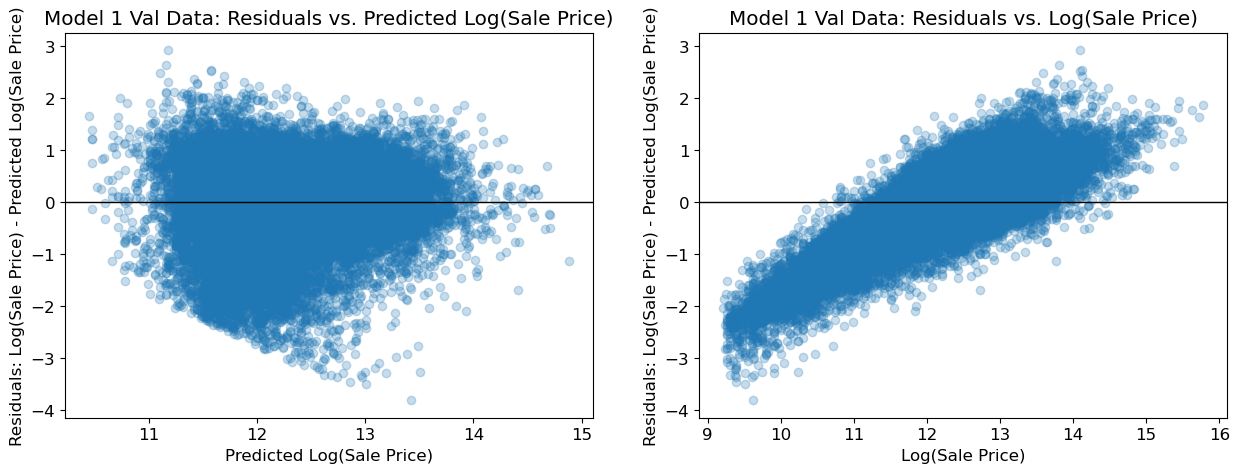

In [18]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))

x_plt1 = y_predict_valid_m1
y_plt1 = y_valid_m1 - y_predict_valid_m1

x_plt2 = y_valid_m1
y_plt2 = y_valid_m1 - y_predict_valid_m1

ax[0].scatter(x_plt1, y_plt1, alpha=.25)
ax[0].axhline(0, c='black', linewidth=1)
ax[0].set_xlabel(r'Predicted Log(Sale Price)')
ax[0].set_ylabel(r'Residuals: Log(Sale Price) - Predicted Log(Sale Price)');
ax[0].set_title("Model 1 Val Data: Residuals vs. Predicted Log(Sale Price)")

ax[1].scatter(x_plt2, y_plt2, alpha=.25)
ax[1].axhline(0, c='black', linewidth=1)
ax[1].set_xlabel(r'Log(Sale Price)')
ax[1].set_ylabel(r'Residuals: Log(Sale Price) - Predicted Log(Sale Price)');
ax[1].set_title("Model 1 Val Data: Residuals vs. Log(Sale Price)")

Notice in the first plot it appears that the lower part of the plot is cutoff along an angled line - this is due to us filtering the data by only considering "Pure Market Filter" = 1, it is not a "pattern" in the residuals that we should try to address.

## Adding a New Feature

### Choosing Candidate Predictors to Add to Model

To see if additional variables might be helpful, we can plot the residuals from the fitted model against a variable that is not in the model. If we see patterns, that indicates we might want to include this additional feature or a transformation of it. 

In Project Part 1, we conducted feature transformation to create several other features related to the Sale Price including `Bedrooms` and `Roof Material`. We'll examine plots of the residuals from Model 1 vs each of these features.

These functions are:
 - `add_total_bedrooms`, 
 - `find_expensive_neighborhoods`, 
 - `add_in_expensive_neighborhood`,
 - `ohe_roof_material`,
 -  `remove_outliers`,  

In [19]:
from feature_func import *

def process_data_candidates(df):
    
    data = df.copy()
    
    data["Log Sale Price"] = np.log(data["Sale Price"])
    
    # Create Log Building Square Feet column
    data["Log Building Square Feet"] = np.log(data["Building Square Feet"])
    
    
    # Create Bedrooms
    data = add_total_bedrooms(data)
     
   
    # Update Roof Material feature with names
    data = substitute_roof_material(data)

    
    # Select columns for comparing residuals
    data = data[['Log Building Square Feet',  'Roof Material', 'Bedrooms', 'Log Sale Price']]

    return data


#Since our residuals are using the validation data, we will just examine these new features on the validation dataset
    
valid_comp = process_data_candidates(val)
    
valid_comp = valid_comp.assign(M1residuals_log=y_valid_m1 - y_predict_valid_m1)

In [20]:
# Run this cell to compare residuals with Bedrooms

import plotly.express as px

px.box(valid_comp, x='Bedrooms', y='M1residuals_log')

Notice, with the exception of the outlier (the properties with 10 bedrooms), the medians of each boxplot align pretty close to 0 on the y-axis (meaning there is no major trend in prediction errors by Number of Bedrooms).

This means we do NOT expect adding the features Bedrooms will help improve our original model. 

In [21]:
# Run this cell to compare residuals vs Roof Material

px.box(valid_comp, x='Roof Material', y='M1residuals_log')

The plot above shows us that the distribution of errors appears to change slightly based on Roof Material. Ideally, the median of each  box plot lines up with 0 on the y-axis (meaning there was no difference in prediction by Roof Material type). Instead, we see some variation from 0 for all except Shingle/Asphalt. These patterns suggest that we may want to try including Roof Material in the model.

## Model 2

Let's add `Roof Material` as a predictor in our model.  We will transform the column to be in terms of the Room Material names. In other words, let's consider a model of the form:

Model 2: 
$$\text{Log Sale Price} =  \theta_1(\text{Log Building Square Feet})  +\theta_2 (\text{Shingle/Asphalt}) $$

$$+ \theta_3 (\text{Tar\&Gravel}) + \theta_4  (\text{Tile})+ \theta_5 (\text{Shake})+  \theta_6(\text{Other})+\theta_7(\text{Slate})$$

In [22]:
# Modeling Step 1:  Process the Data
from feature_func import *
ohe_roof_material

def process_data_m2(df):

    """ 
    Takes in a DataFrame of cleaned data and performs feature engineering to use for Model 2.
    Includes creating a Log Sale Price column, a Log Building Square Feet Column, 
    and one-hot encoding roof materials to use in the model.
    Once you have one-hot encoded the roof materials, you should drop the 
    original (not encoded) column `Roof Material` as it will not be used in the model.

    Outputs a DataFrame with only the features and response/output used in model 2.  
 
    """

    data = df.copy()

    # add log sale price column
    # add log building square feet column
    data['Log Sale Price'] = np.log(data['Sale Price'])
    data['Log Building Square Feet'] = np.log(data['Building Square Feet'])
    
    # use built in one hot encoder to add ohe
    data = ohe_roof_material(data)
    
    # drop the original roof material column
    data.drop(columns=['Roof Material'])
    
    # then, return only the features and response/output used in model 2
    return data[['Log Sale Price', 'Log Building Square Feet', 'Roof Material_1.0', \
                'Roof Material_2.0', 'Roof Material_3.0', 'Roof Material_4.0', \
                'Roof Material_5.0', 'Roof Material_6.0']]

# Use the same `tr` and `val` datasets from Question 3 (otherwise the validation errors aren't comparable), 
# Don't resplit the data.  

# Process the data for Model 2
processed_train_m2 = process_data_m2(tr)
processed_val_m2 = process_data_m2(val)

# Create X (dataframe) and Y (series) to use in the model
X_train_m2 = processed_train_m2.drop(columns = 'Log Sale Price')
y_train_m2 = processed_train_m2['Log Sale Price']

X_valid_m2 = processed_val_m2.drop(columns = 'Log Sale Price')
y_valid_m2 = processed_val_m2['Log Sale Price']

# Take a look at the result
display(X_train_m2.head())
display(y_train_m2.head())

display(X_valid_m2.head())
display(y_valid_m2.head())

,Log Building Square Feet,Roof Material_1.0,Roof Material_2.0,Roof Material_3.0,Roof Material_4.0,Roof Material_5.0,Roof Material_6.0
21302,6.871091,1.0,0.0,0.0,0.0,0.0,0.0
19451,7.576610,1.0,0.0,0.0,0.0,0.0,0.0
32018,6.891626,1.0,0.0,0.0,0.0,0.0,0.0
144262,7.186901,1.0,0.0,0.0,0.0,0.0,0.0
197227,7.576610,1.0,0.0,0.0,0.0,0.0,0.0


21302     11.738466
19451     12.100712
32018     12.577291
144262    12.502467
197227    12.449019
Name: Log Sale Price, dtype: float64

,Log Building Square Feet,Roof Material_1.0,Roof Material_2.0,Roof Material_3.0,Roof Material_4.0,Roof Material_5.0,Roof Material_6.0
17112,7.487174,1.0,0.0,0.0,0.0,0.0,0.0
189337,7.688913,1.0,0.0,0.0,0.0,0.0,0.0
141725,6.985642,1.0,0.0,0.0,0.0,0.0,0.0
9776,6.846943,1.0,0.0,0.0,0.0,0.0,0.0
81676,7.096721,1.0,0.0,0.0,0.0,0.0,0.0


17112     12.100707
189337    12.460715
141725    12.165251
9776      11.982929
81676     11.719940
Name: Log Sale Price, dtype: float64

#### Modeling STEP 2:  Create a Multiple Linear Regression Model

In [23]:
# Modeling STEP 2:  Create and Fit a Multiple Linear Regression Model
model2 = lm.LinearRegression()
model2.fit(X_train_m2, y_train_m2)

# your code above this line to create and fit regression model for Model 2
y_predict_train_m2 = model2.predict(X_train_m2)

y_predict_valid_m2 = model2.predict(X_valid_m2)

#### MODELING STEP 3:  Evaluate the RMSE for your model

In [24]:
# MODELING STEP 3:  Evaluate the RMSE for the model
# Training and test errors for the model (in its original values of dollars, not log)
training_error[1] = rmse(np.exp(y_predict_train_m2), np.exp(y_train_m2))
validation_error[1] = rmse(np.exp(y_predict_valid_m2), np.exp(y_valid_m2))

print("2nd Model \nTraining RMSE: $ {}\nValidation RMSE: $ {}\n". \
      format(training_error[1], validation_error[1]))


2nd Model 
Training RMSE: $ 242876.6284360605
Validation RMSE: $ 245529.28812096303



#### MODELING STEP 4:  Conduct 5-fold cross validation for model and output CV RMSE

In [25]:
# MODELING STEP 4:  Conduct 5-fold cross validation for model and output CV RMSE
# Create a new model to use for cross validation of m2 
linear_model_m2_cv = lm.LinearRegression()

# Process the entire cleaned training_val dataset using the m2 pipeline
processed_full_m2 = process_data_m2(tr_val_clean)

# Split the processed_full_m2 Dataset into X and Y to use in models.
X_full_m2 = processed_full_m2.drop(columns = 'Log Sale Price')
y_full_m2 = processed_full_m2['Log Sale Price']

# Run cross_validate_rmse function:
cv_error_m2  = cross_validate_rmse(linear_model_m2_cv, X_full_m2, y_full_m2)

# Save the cross validation error for model 1 in our list to compare different models:

cv_error[1] = cv_error_m2

print("2nd Model Cross Validation RMSE: {}".format(cv_error[1]))

2nd Model Cross Validation RMSE: 243152.2926084619


#### MODELING STEP 5:  Plot bar graph comparing RMSEs of Model 2 and Model 1 and side-by-side residuals

In [26]:
# MODELING STEP 5:  Just run this cell to Plot bar graph comparing RMSEs of Model 2 and Model 1 and side-by-side residuals

model_names[1] = "M2: log(bsqft)+Roof"

fig = go.Figure([
go.Bar(x = model_names, y = training_error, name="Training RMSE"),
go.Bar(x = model_names, y = validation_error, name="Validation RMSE"),
go.Bar(x = model_names, y = cv_error, name="Cross Val RMSE")
])

fig.update_yaxes(range=[180000,260000], title="RMSE")

fig


Text(0.5, 1.0, 'Model 2 Val Data: Residuals vs. Log(Sale Price)')

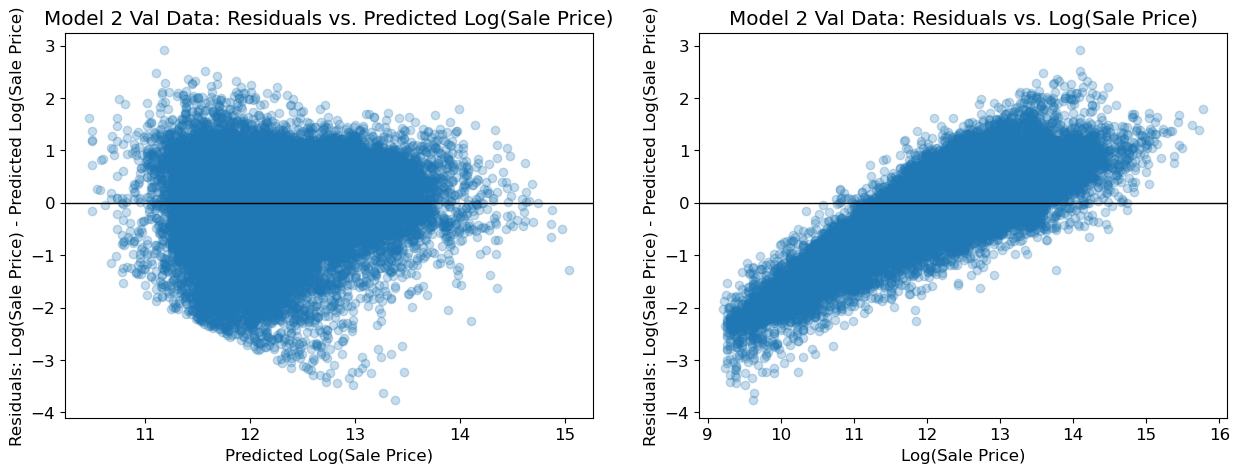

In [27]:
# MODELING STEP 5 cont'd:  Plot 2 side-by-side residual plots (similar to Question 3, for validation data)
fig, ax = plt.subplots(1,2, figsize=(15, 5))


x_plt1 = y_predict_valid_m2
y_plt1 = y_valid_m2 - y_predict_valid_m2

x_plt2 = y_valid_m2
y_plt2 = y_valid_m2 - y_predict_valid_m2


ax[0].scatter(x_plt1, y_plt1, alpha=.25)
ax[0].axhline(0, c='black', linewidth=1)
ax[0].set_xlabel(r'Predicted Log(Sale Price)')
ax[0].set_ylabel(r'Residuals: Log(Sale Price) - Predicted Log(Sale Price)');
ax[0].set_title("Model 2 Val Data: Residuals vs. Predicted Log(Sale Price)")

ax[1].scatter(x_plt2, y_plt2, alpha=.25)
ax[1].axhline(0, c='black', linewidth=1)
ax[1].set_xlabel(r'Log(Sale Price)')
ax[1].set_ylabel(r'Residuals: Log(Sale Price) - Predicted Log(Sale Price)');
ax[1].set_title("Model 2 Val Data: Residuals vs. Log(Sale Price)")

We only see a slight decrease in the RMSE with this 2nd model, and our residuals look nearly the same as Model 1, even though the boxplots of Roof Material vs the residuals of Model 1 had indicated it might be a useful feature to add to the model.  

Although there was variation in the boxplots we didn't check the number of data points actually in each different Roof Material Category, which will affect how useful the feature will be in reducing the RMSE:

In [28]:
val_data_prop_roof_type = valid_comp['Roof Material'].value_counts()/ \
valid_comp['Roof Material'].value_counts().sum()

val_data_prop_roof_type

Roof Material
Shingle/Asphalt    0.952293
Tar&Gravel         0.022793
Shake              0.008783
Tile               0.006841
Other              0.005497
Slate              0.003794
Name: count, dtype: float64

### Choose an additional feature for Model 3 

To choose my feature, I decided to plot different features from the data against log sale price. Because we're trying to predict log sale price, the additional feature added should have a strong relationship with log sale price in order to reduce the RMSE and improve our residual plots. I picked a couple features that I thought would have a relationship with log sale price, including age, land square feet, estimate (land), and estimate (building). 

As seen from the first graph of Age vs. Log Sale Price, there doesn't seem to be a clear relationship between the two features. The plot is largely spread out with no apparent pattern. Similarly, from the second graph of 
Land Square Feet vs. Log Sale Price there seemed to be a faint logarithmic relationship, but not a very strong or clear one. Thus, I ruled out picking age or land square feet as additional features in my model. 

In contrast, from the third graph of Estimate (Land) vs. Log Sale Price, a clear logarithmic relationship between estimate (land) and log sale price can be seen. Similarly, the fourth graph of Estimate (Building) vs. Log Sale Price displays an even stronger logarithmic relationship between the two features. Thus, becuase estimate (building) seemed to have the strongest relationship with log sale price (what we're trying to predict), I decided to add Estimate (Building) as a new feature into my model. 

Additionally, I noticed that the relationship between estimate (building) and log sale price was not linear. Because we want a multiple linear regression model, we can use the Tukey Mosteller diagram to linearize the relationship between the two features. Using the Tukey Mosteller diagram, we realize that to linearize the relationship between log sale price and estimate (building), we can use log(estimate (building)) as the additional feature in our linear model.

From the codebook, the feature "estimate (building)" describes the final estimated market value of building from the prior tax year. I noticed that estimate (building) had a strong logarithmic relationship with log sale price by graphing the two on a scatter plot (shown in the fourth box below). To linearize this relationship, I used the Tukey Mosteller Diagram, and decided to add log(estimate (building)) as a feature to my model. I chose to use this specific feature because it has a clear relationship with log sale price, which is what our model is trying to predict, and thus will also have a positive impact on the RMSE (lowering it) and improve our residual graphs. 

Text(0.5, 1.0, 'Age vs. Log Sale Price')

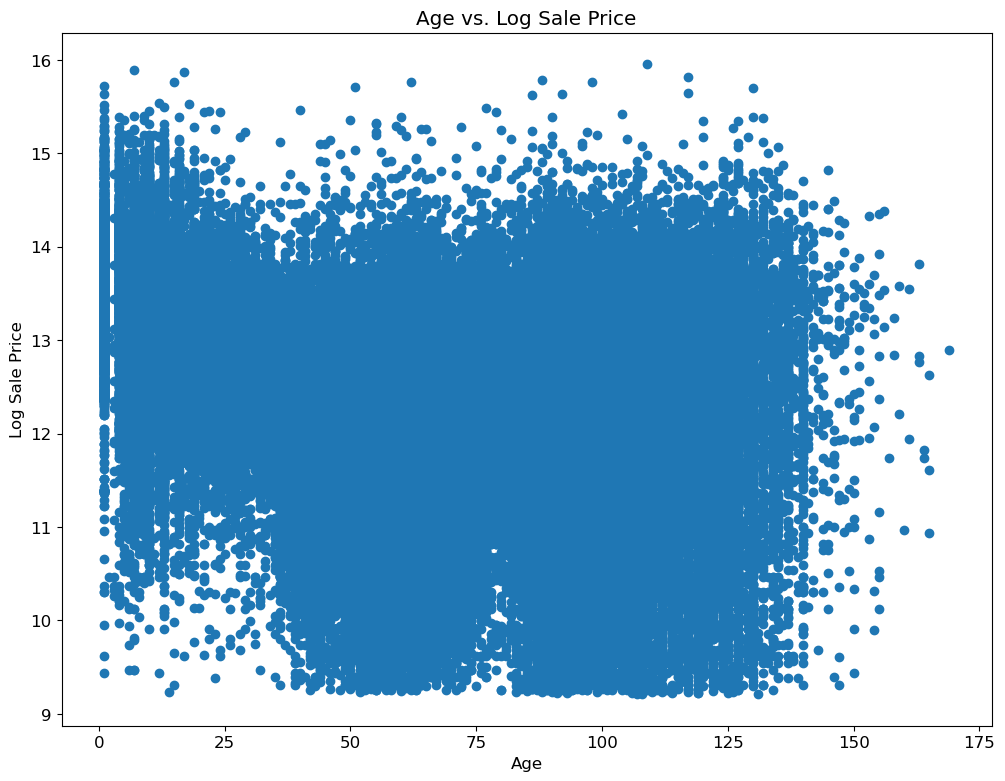

In [29]:
# make copy and add in the log sale price column (since this is what we want to predict)
test_feature_data = tr_val_clean.copy()
test_feature_data['Log Sale Price'] = np.log(test_feature_data['Sale Price'])

# plot log sale price against age and see if there's a clear relationship
plt.scatter(test_feature_data['Age'], test_feature_data['Log Sale Price'])
plt.xlabel("Age")
plt.ylabel("Log Sale Price")
plt.title("Age vs. Log Sale Price")
# since the graph is very spread out 
# we cannot see a clear relationship between age and thus won't use age as a feature 
# Show work in this cell exploring data to determine which feature to add

Text(0.5, 1.0, 'Land Square Feet vs. Log Sale Price')

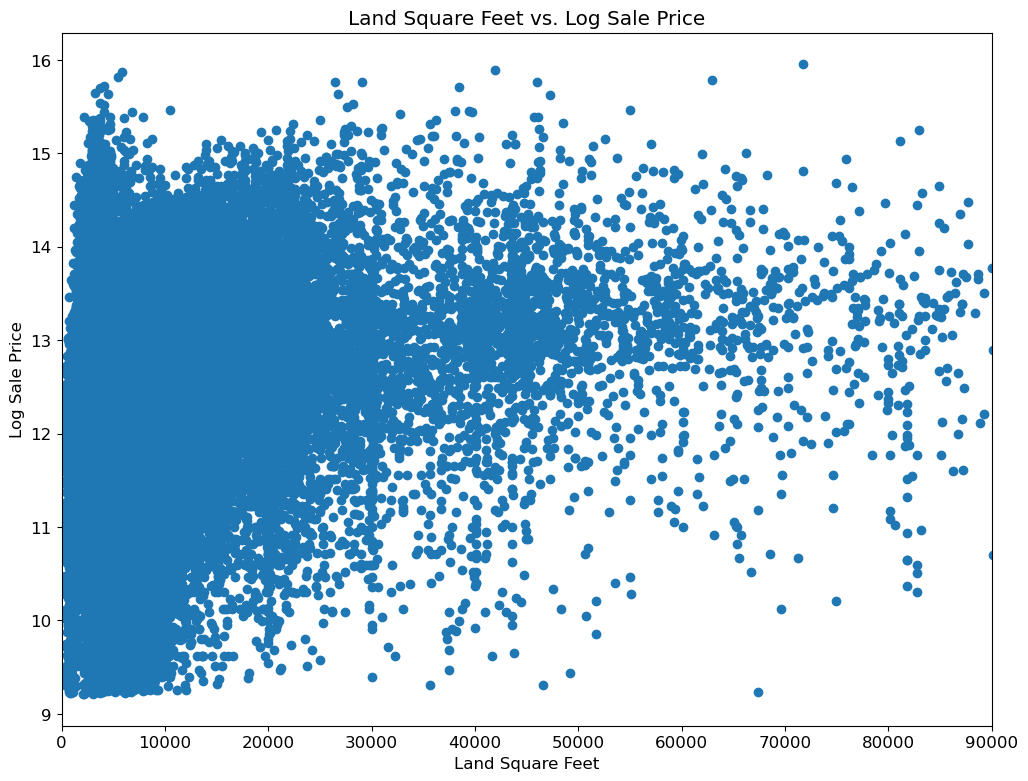

In [30]:
# plot log sale price against land square feet and see if there's a clear relationship
plt.scatter(test_feature_data['Land Square Feet'], test_feature_data['Log Sale Price'])
# resize to zoom in closer as outlier made the graph hard to see
plt.xlim([0,90000])
plt.xlabel("Land Square Feet")
plt.ylabel("Log Sale Price")
plt.title("Land Square Feet vs. Log Sale Price")
# since the graph is also spread out 
# we cannot see a clear relationship between age and thus won't use land size as a feature 

# Optional code cell for additional work exploring data/ explaining which feature you chose.

Text(0.5, 1.0, 'Estimate (Land) vs. Log Sale Price')

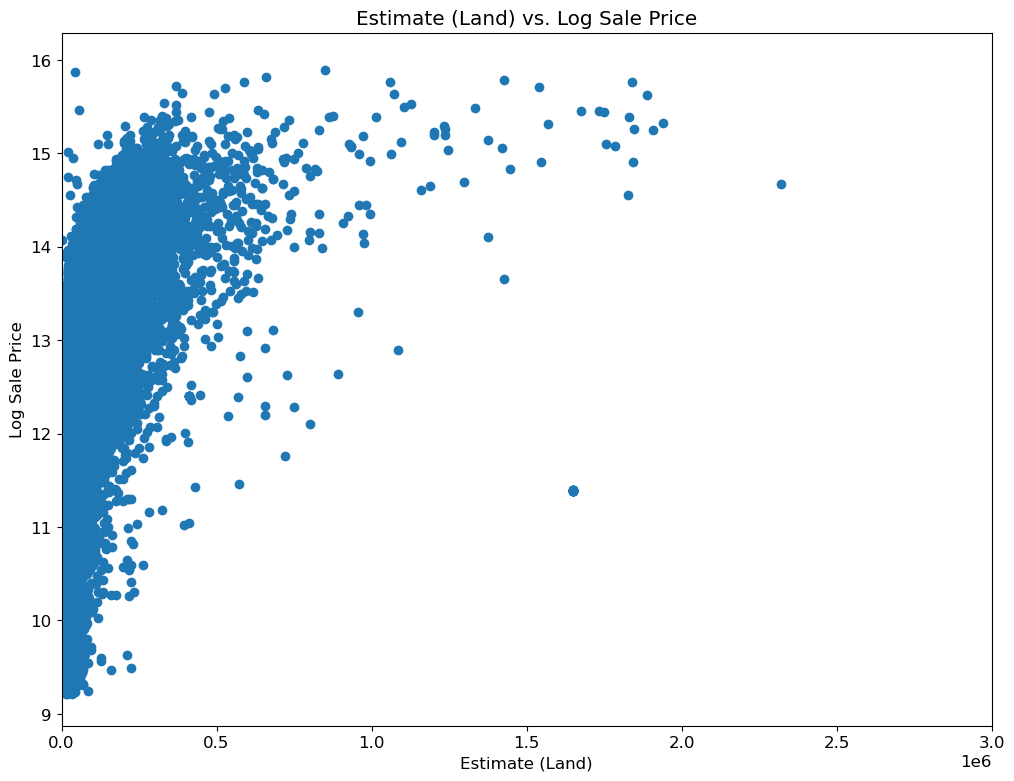

In [31]:
# plot log sale price against land square feet and see if there's a clear relationship
plt.scatter(test_feature_data['Estimate (Land)'], test_feature_data['Log Sale Price'])
# resize to zoom in closer
plt.xlim([0,3000000])
plt.xlabel('Estimate (Land)')
plt.ylabel("Log Sale Price")
plt.title("Estimate (Land) vs. Log Sale Price")

# we can see from the graph below, that there is a clearer relationship between
# log sale price and estimate (land). looks like a logarithmic relationship (could transform)
# thus, the clear relationship makes this a candidate for our new feature.

# Optional code cell for additional work exploring data/ explaining which feature you chose.

Text(0.5, 1.0, 'Estimate (Building) vs. Log Sale Price')

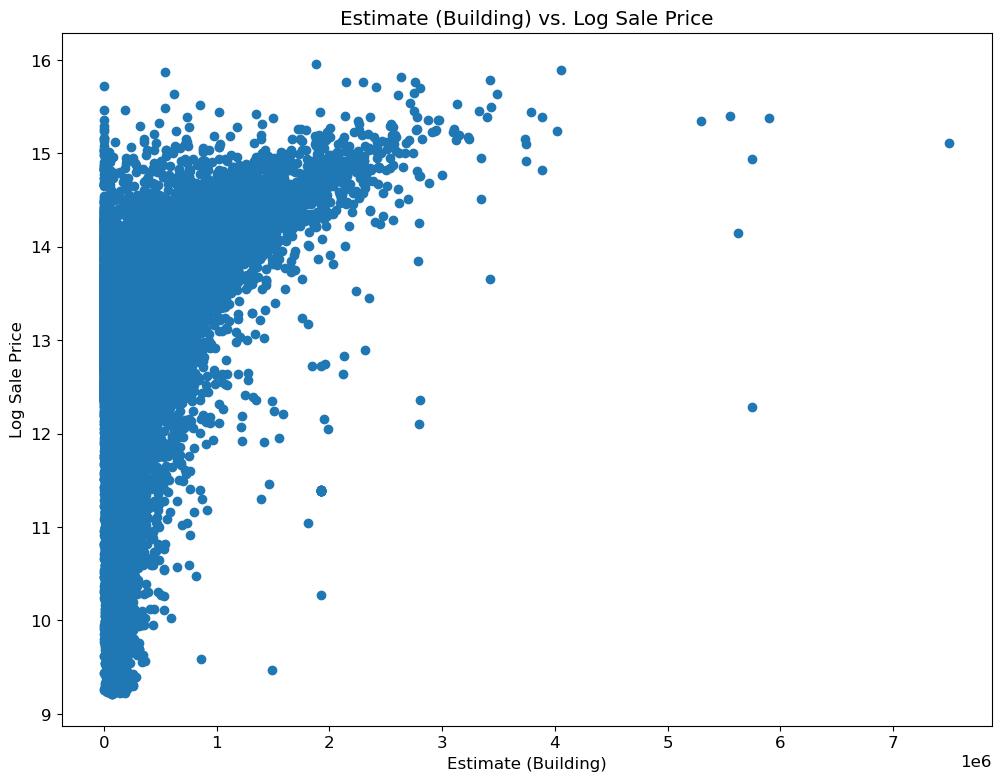

In [32]:
# plot log sale price against land square feet and see if there's a clear relationship
plt.scatter(test_feature_data['Estimate (Building)'], test_feature_data['Log Sale Price'])
# resize to zoom in closer as outlier made the graph hard to see
plt.xlabel('Estimate (Building)')
plt.ylabel("Log Sale Price")
plt.title("Estimate (Building) vs. Log Sale Price")
# we can see from the graph below, that there is a very clear relationship between
# log sale price and estimate (building)
# looks like a logarithmic relationship which we could transform to be linear and fit our model
# thus, the clear relationship makes this the best candidate for our new feature out of
# the ones we considered

# Optional code cell for additional work exploring data/ explaining which feature you chose.

### Create Model 3

In [33]:
# Modeling Step 1:  Process the Data

from feature_func import *
ohe_roof_material

def process_data_m3(df):
    
    data = df.copy()
        
    # add log sale price column
    # add log building square feet column
    
    data['Log Sale Price'] = np.log(data['Sale Price'])
    data['Log Building Square Feet'] = np.log(data['Building Square Feet'])
    
    # from the graph above, estimate (building) had a logarithmic relationship
    # use log estimate (building) to linearize the relationship
    # some estimate (building) valuse are 0, so we'll replace with the average instead
    data['Estimate (Building)'] = data['Estimate (Building)'] \
    .replace(0, data['Estimate (Building)'].mean())
    
    data['Log Estimate (Building)'] = np.log(data['Estimate (Building)'])
    
    # use built in one hot encoder to add ohe
    data = ohe_roof_material(data)
    
    # drop the original roof material column
    data.drop(columns=['Roof Material'])
    
    # return the log sale price, building square feet, roof material, and log estiamte building
    # since we are using these features in our new model
    return data[['Log Sale Price', 'Log Building Square Feet', 'Roof Material_1.0', \
                'Roof Material_2.0', 'Roof Material_3.0', 'Roof Material_4.0', \
                'Roof Material_5.0', 'Roof Material_6.0', 'Log Estimate (Building)']]

    

# Process the data for Model 3 (using the same tr and val datatsets we created in Question 3) 
processed_train_m3 = process_data_m3(tr) 

processed_val_m3 = process_data_m3(val) 

# Create X (Dataframe) and y (series) to use to train the model
X_train_m3 = processed_train_m3.drop(columns='Log Sale Price')
y_train_m3 = processed_train_m3['Log Sale Price']

X_valid_m3 = processed_val_m3.drop(columns='Log Sale Price')
y_valid_m3 = processed_val_m3['Log Sale Price']


# Take a look at the result
display(X_train_m3.head())
display(y_train_m3.head())

display(X_valid_m3.head())
display(y_valid_m3.head())

,Log Building Square Feet,Roof Material_1.0,Roof Material_2.0,Roof Material_3.0,Roof Material_4.0,Roof Material_5.0,Roof Material_6.0,Log Estimate (Building)
21302,6.871091,1.0,0.0,0.0,0.0,0.0,0.0,11.248048
19451,7.576610,1.0,0.0,0.0,0.0,0.0,0.0,11.510021
32018,6.891626,1.0,0.0,0.0,0.0,0.0,0.0,12.096425
144262,7.186901,1.0,0.0,0.0,0.0,0.0,0.0,12.042259
197227,7.576610,1.0,0.0,0.0,0.0,0.0,0.0,12.612637


21302     11.738466
19451     12.100712
32018     12.577291
144262    12.502467
197227    12.449019
Name: Log Sale Price, dtype: float64

,Log Building Square Feet,Roof Material_1.0,Roof Material_2.0,Roof Material_3.0,Roof Material_4.0,Roof Material_5.0,Roof Material_6.0,Log Estimate (Building)
17112,7.487174,1.0,0.0,0.0,0.0,0.0,0.0,11.882211
189337,7.688913,1.0,0.0,0.0,0.0,0.0,0.0,12.110112
141725,6.985642,1.0,0.0,0.0,0.0,0.0,0.0,11.760410
9776,6.846943,1.0,0.0,0.0,0.0,0.0,0.0,11.569589
81676,7.096721,1.0,0.0,0.0,0.0,0.0,0.0,11.272763


17112     12.100707
189337    12.460715
141725    12.165251
9776      11.982929
81676     11.719940
Name: Log Sale Price, dtype: float64

In [34]:
# Modeling STEP 2:  Create and Fit a Multiple Linear Regression Model
model3 = lm.LinearRegression()
model3.fit(X_train_m3, y_train_m3)
# your code above this line to create and fit regression model for Model 3
y_predict_train_m3 = model3.predict(X_train_m3)

y_predict_valid_m3 = model3.predict(X_valid_m3)

In [35]:
# MODELING STEP 3:  Evaluate the RMSE for your model
# Training and validation errors for the model (in units dollars, not log(dollars))
training_error[2] = rmse(np.exp(y_predict_train_m3), np.exp(y_train_m3.values))
validation_error[2] = rmse(np.exp(y_predict_valid_m3), np.exp(y_valid_m3.values))


(print("3rd Model \nTraining RMSE: $ {}\nValidation RMSE: {}\n"
       .format(training_error[2], validation_error[2]))
)


3rd Model 
Training RMSE: $ 187818.9320418833
Validation RMSE: 184542.2931086052



In [36]:
# MODELING STEP 4:  Conduct 5-fold cross validation for model and output RMSE

linear_model_m3_cv = lm.LinearRegression()


# Process the entire cleaned training_val dataset using the m3 pipeline
processed_full_m3 = process_data_m3(tr_val_clean)

# Split the processed_full_m3 Dataset into X and y to use in models.
X_full_m3 = processed_full_m3.drop(columns='Log Sale Price')
y_full_m3 = processed_full_m3['Log Sale Price']


# Run cross_validate_rmse function:
cv_error_m3  = cross_validate_rmse(linear_model_m3_cv, X_full_m3, y_full_m3)

# Save the cross validation error for model 3 in our list to compare different models:

cv_error[2] = cv_error_m3

print("3rd Model Cross Validation RMSE: {}".format(cv_error[2]))

3rd Model Cross Validation RMSE: 187374.43757874527


In [37]:
# MODELING STEP 5:  Add a name for your 3rd model describing the features 
#and run this cell to Plot bar graph all 3 models

model_names[2] = "M3: log(bsqft)+Roof+log(est. building)"


fig = go.Figure([
go.Bar(x = model_names, y = training_error, name="Training RMSE"),
go.Bar(x = model_names, y = validation_error, name="Validation RMSE"),
go.Bar(x = model_names, y = cv_error, name="Cross Val RMSE")
])

fig.update_yaxes(range=[150000,260000], title="RMSE")

fig

Text(0.5, 1.0, 'Model 3 Val Data: Residuals vs. Log(Sale Price)')

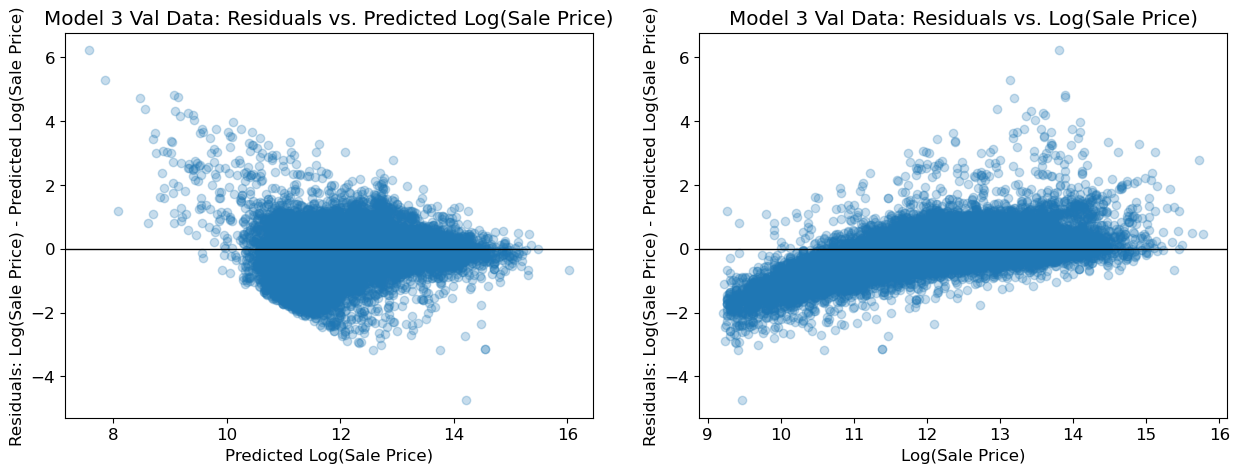

In [38]:
# MODELING STEP 5 cont'd:  Plot 2 side-by-side residual plots 
#(similar to Question 3, for validation data)

fig, ax = plt.subplots(1,2, figsize=(15, 5))

x_plt1 = y_predict_valid_m3
y_plt1 = y_valid_m3 - y_predict_valid_m3

x_plt2 = y_valid_m3
y_plt2 = y_valid_m3 - y_predict_valid_m3

ax[0].scatter(x_plt1, y_plt1, alpha=.25)
ax[0].axhline(0, c='black', linewidth=1)
ax[0].set_xlabel(r'Predicted Log(Sale Price)')
ax[0].set_ylabel(r'Residuals: Log(Sale Price) - Predicted Log(Sale Price)');
ax[0].set_title("Model 3 Val Data: Residuals vs. Predicted Log(Sale Price)")

ax[1].scatter(x_plt2, y_plt2, alpha=.25)
ax[1].axhline(0, c='black', linewidth=1)
ax[1].set_xlabel(r'Log(Sale Price)')
ax[1].set_ylabel(r'Residuals: Log(Sale Price) - Predicted Log(Sale Price)');
ax[1].set_title("Model 3 Val Data: Residuals vs. Log(Sale Price)")

My cross validation RMSE for Model 3 was the lowest out of the three models. A lower RMSE indicates more "accurate" predictions/lower average loss across the data. Thus, based off of the RMSEs, Model 3 appears to be the best model compared to the first two.

Additionally, another way to evaluate whether a model is a good fit to our data is to consider the residual plots of each model. From the previous code, we noticed that the two side by side residual plots looked about the same for both Model 1 and Model 2. For the residual plots of Model 1 and Model 2, I noticed both models were still overestimating inexpensive houses and underestimating more expensive houses. 

Looking at Model 3, we can notice that while there is still some overestimation for more inexpensive houses and some underestimation for more expensive houses, Model 3 more accurately predicts the sale prices for both inexpensive and expensive houses (reduces the overestimation of inexpensive and underestimation of expensive houses). We can also see that Model 3's residual graph is more tightly clustered around the x-axis, indicating a fairer and more accurate model than Model 1 and Model 2. 

While my model has significantly improved from Model 1 and Model 2, my model still shows overestimating lower prices houses (around log(8) to log(10)) as well as underestimating higher prices houses (around log(14) to log(16)). I could try to address this in my next round of modeling by adding more features to my model in hopes of making it more accurate, perhaps by considering quantitative features the next time around. However, I would want to avoid overfitting by adding too many features to my model. I could also consider trying out different feature functions on my current features to see if that yields a better model that avoids overestimating lower prices houses and underestimating higher prices house as much.

If I had more time, I would consider using other techniques of finding the best additional features to my model, instead of simply graphing features and picking the one that seemed to have a clear relationship with log sale price. I would instead try using regularization to improve my model by limiting the complexity/number of features added to my model using a penalty term. This way, I can choose the features of my model by picking those that are most important in predicting the log sale prices of houses instead of my original guess and check method. 

In the context of estimating the value of houses, the residual is the difference between the actual sale price of a home and the predicted sale price of a home using our model. Because the property tax paid by the homeowner is determined based on the estimated value of a home, the residual's sign (either positive or negative) impacts the amount of property tax the homeowner needs to pay. 

If the residual is positive, then the actual sale price of a house is larger than the predicted sale price of a home from our model. Thus, a positive residual corresponds to an underestimation of a house's value. If the house is underestimated, then the homeowner pays less property tax than they would have had to if the house had been valued at its actual price (since less expensive houses correspond to lower property taxes imposed on the homeowner). 

If the residual is negative, then that means that the actual sale price of a house is smaller than the predicted sale price of a home from our model. Thus, a negative residual corresponds to an overestimation of a house's value. If the house is overestimated, then the homeowner pays more property tax than they would have had to if the house had been valued at its actual price (since more expensive houses correspond to higher property taxes imposed on the homeowner). 

<!-- END QUESTION -->

In the case of the Cook County Assessor’s Office, Chief Data Officer Rob Ross states that fair property tax rates are contingent on whether property values are assessed accurately - that they’re valued at what they’re worth, relative to properties with similar characteristics. This implies that having a more accurate model results in fairer assessments. The goal of the property assessment process for the CCAO, then, is to be as accurate as possible. 

When the use of algorithms and statistical modeling has real-world consequences, we often refer to the idea of fairness as a measurement of how socially responsible our work is. Fairness is incredibly multifaceted: Is a fair model one that minimizes loss - one that generates accurate results? Is it one that utilizes "unbiased" data? Or is fairness a broader goal that takes historical contexts into account?

These approaches to fairness are not mutually exclusive. If we look beyond error functions and technical measures of accuracy, we'd not only consider _individual_ cases of fairness, but also what fairness - and justice - means to marginalized communities on a broader scale. We'd ask: What does it mean when homes in predominantly Black and Hispanic communities in Cook County are consistently overvalued, resulting in proportionally higher property taxes? When the white neighborhoods in Cook County are consistently undervalued, resulting in proportionally lower property taxes? 

Having "accurate" predictions doesn't necessarily address larger historical trends and inequities, and fairness in property assessments in taxes works beyond the CCAO's valuation model. Disassociating accurate predictions from a fair system is vital to approaching justice at multiple levels. Take Evanston, IL - a suburb in Cook County - as an example of housing equity beyond just improving a property valuation model: Their City Council members [recently approved reparations for African American residents](https://www.usnews.com/news/health-news/articles/2021-03-23/chicago-suburb-approves-government-reparations-for-black-residents).

Reflecting back on my explorations, I think what makes a model's predictions of property values for tax assessment purposes "fair" is a combination of both a low RMSE and good prediction accuracy. I think that a combination of both is needed for a "fair" model prediction because as we have seen from the graphs above, a model with a low RMSE is not necessarily completely accurate and thus not necessarily fair. 

From Models 1 and 2, which had the two highest RMSE out of the three models, we can see that there was noticeable overestimation of lower prices houses and underestimation of higher prices houses, which led us to classify the model as corresponing to regressive taxation (percentage tax rate higher for homeowners of less expensive houses). In comparison, Model 3 has a significantly lower RMSE as well as residual plots that showed less overestimation of lower prices houses and less underestimation of higher prices houses. Thus, I believe that part of what makes a model's predictions of property values for tax assessment purposes "fair" is a low RMSE.

However, from Model 3 we also noticed that while it has the lowest RMSE, there is still some overestimation of lower prices houses and underestimation of higher prices houses, indicating that the model is not completely accurate in its predictions. If the model was completely accurate, then the residuals for each house sale price estimation would be $0$, with a residual plot of data points tightly clustered around the horizontal axis. Thus, I also think that in addition to a low RMSE (which helped the accuracy of our predictions), we should also analyze the the accuracy of our model as a low RMSE doesn't solely indicate a fair model. Therefore, I think that a combination of both is needed for a "fair" model prediction. 

## Model 4: Creating a new model - How low can we go?

In [39]:
# instead of guessing and checking features to add to our model
# i'll try using regularization to choose the most
#     important features in predicting log sale price
# try to build a model with all of the features but restrict coefficient size
# the penalty term limits complexity of the model to prioritize important features first
# working with original tr and val for training and validation sets

# i dropped description and modeling group because they're strings and can't have functions applied to it
# dropped use and pure market filter because it was all 1s, which resulted in NaN
full_set = tr_val_clean.copy().drop(columns=['Description', 'Modeling Group', \
                                             'Use', 'Pure Market Filter'])
x_tr_val = full_set.drop(columns='Sale Price')
# y_tr_val = np.log(full_set['Sale Price'])

# create a training copy that drops the same columns as well
my_training = tr.copy().drop(columns=['Description', 'Modeling Group', \
                                      'Use', 'Pure Market Filter'])

# x_train = my_training.drop(columns='Sale Price')
y_train = np.log(my_training['Sale Price'])

# to use penalized regression, we first standarized all features in the training set tr so we can 
# compare the magnitudes of regression coefficients for all the feature variables the same way
my_training_centered = my_training - my_training.mean()
my_training_scaled = my_training_centered/my_training_centered.std()

# trial and errored different alphas until i got 
# a few features that I could add to my model 
from sklearn.linear_model import Lasso
my_model = Lasso(alpha = 0.2)
my_model.fit(my_training_scaled.drop(columns='Sale Price'), y_train)

# print out matrix with the coefficients
print(my_model.coef_)

# print out the columns labels that correspond to the non zero coefficients
print(x_tr_val.loc[:,np.abs(my_model.coef_) > 0].columns)

[-0.          0.         -0.          0.         -0.         -0.
  0.          0.         -0.         -0.         -0.          0.
  0.          0.          0.         -0.          0.          0.
 -0.         -0.          0.          0.          0.          0.
 -0.          0.          0.          0.          0.          0.
  0.14483184 -0.         -0.         -0.          0.          0.2327499
  0.         -0.          0.19168234 -0.         -0.         -0.
  0.         -0.         -0.          0.          0.          0.
  0.          0.          0.          0.         -0.          0.
 -0.         -0.          0.        ]
Index(['Building Square Feet', 'Estimate (Building)', 'Latitude'], dtype='object')


correlation of log sale price and estimate (building): 0.6503350726066052
correlation of log sale price and building square feet: 0.5857066884584553
correlation of log sale price and latitude: 0.5476685229263545


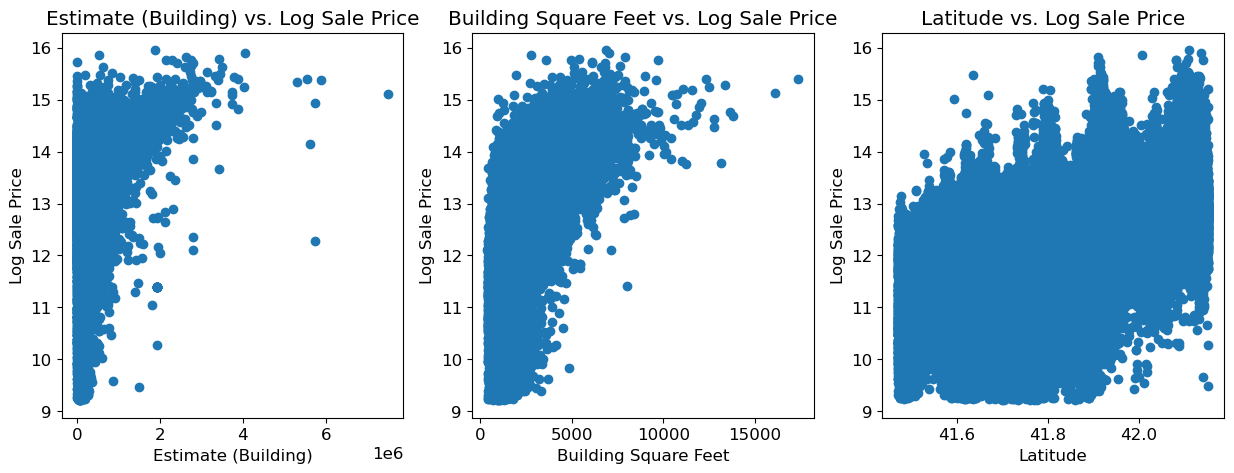

In [40]:
test_feature_data = tr_val_clean.copy()
test_feature_data['Log Sale Price'] = np.log(test_feature_data['Sale Price'])

fig, ax = plt.subplots(1,3, figsize=(15, 5))

ax[0].scatter(test_feature_data['Estimate (Building)'], test_feature_data['Log Sale Price'])
ax[0].set_xlabel('Estimate (Building)')
ax[0].set_ylabel("Log Sale Price");
ax[0].set_title("Estimate (Building) vs. Log Sale Price")
print("correlation of log sale price and estimate (building): " + \
      str(test_feature_data['Log Sale Price'].corr(test_feature_data['Estimate (Building)'])))


ax[1].scatter(test_feature_data['Building Square Feet'], test_feature_data['Log Sale Price'])
ax[1].set_xlabel('Building Square Feet')
ax[1].set_ylabel("Log Sale Price");
ax[1].set_title("Building Square Feet vs. Log Sale Price")
print("correlation of log sale price and building square feet: " + \
      str(test_feature_data['Log Sale Price'].corr(test_feature_data['Building Square Feet'])))

ax[2].scatter(test_feature_data['Latitude'], test_feature_data['Log Sale Price'])
ax[2].set_xlabel('Latitude')
ax[2].set_ylabel("Log Sale Price");
ax[2].set_title("Latitude vs. Log Sale Price")
print("correlation of log sale price and latitude: " + \
      str(test_feature_data['Log Sale Price'].corr(test_feature_data['Latitude'])))
# Optional code cell for additional work exploring data/ explaining which feature you chose.

## Creating Model 4

In [41]:
# Modeling Step 1:  Process the Data
from feature_func import *
...

def process_data_ec(df, dataset_type):
    data = df.copy()
    # add log sale price column
    # add log building square feet column
    if(dataset_type == 3):
        data['Log Building Square Feet'] = np.log(data['Building Square Feet'])
        
        data['Estimate (Building)'] = data['Estimate (Building)'] \
                        .replace(0, data['Estimate (Building)'].mean())
        data['Log Estimate (Building)'] = np.log(data['Estimate (Building)'])    
    
    # return the building square feet, latitude, and log estimate building
    # since we are using these features in our new model
        return data[['Log Building Square Feet', \
                 'Log Estimate (Building)', 'Latitude']]
    else:
        data['Log Sale Price'] = np.log(data['Sale Price'])
        data['Log Building Square Feet'] = np.log(data['Building Square Feet'])

        # from the graph above, estimate (building) had a logarithmic relationship
        # use log estimate (building) to linearize the relationship
        # some estimate (building) valuse are 0, so we'll replace with the average instead,
        data['Estimate (Building)'] = data['Estimate (Building)']. \
                replace(0, data['Estimate (Building)'].mean())
        data['Log Estimate (Building)'] = np.log(data['Estimate (Building)'])    

        # return the log sale price, building square feet, latitude, and log estiamte building
        # since we are using these features in our new model
        return data[['Log Sale Price', 'Log Building Square Feet', \
                     'Log Estimate (Building)', 'Latitude']]

# Use the same original train and valid datasets from 3a (otherwise the 
# validation errors aren't comparable).  Don't resplit the data.  
    
# Process the data 
processed_train_ec = process_data_ec(tr, dataset_type=1)

processed_val_ec = process_data_ec(val, dataset_type=2)


X_train_ec = processed_train_ec.drop(columns='Log Sale Price')
y_train_ec = processed_train_ec['Log Sale Price']

X_valid_ec = processed_val_ec.drop(columns='Log Sale Price')
y_valid_ec = processed_val_ec['Log Sale Price']

# Take a look at the result
display(X_train_ec.head())
display(y_train_ec.head())

display(X_valid_ec.head())
display(y_valid_ec.head())

,Log Building Square Feet,Log Estimate (Building),Latitude
21302,6.871091,11.248048,41.866934
19451,7.576610,11.510021,41.899682
32018,6.891626,12.096425,41.792931
144262,7.186901,12.042259,42.012002
197227,7.576610,12.612637,41.709079


21302     11.738466
19451     12.100712
32018     12.577291
144262    12.502467
197227    12.449019
Name: Log Sale Price, dtype: float64

,Log Building Square Feet,Log Estimate (Building),Latitude
17112,7.487174,11.882211,41.617927
189337,7.688913,12.110112,41.715942
141725,6.985642,11.760410,41.782758
9776,6.846943,11.569589,41.734528
81676,7.096721,11.272763,41.561748


17112     12.100707
189337    12.460715
141725    12.165251
9776      11.982929
81676     11.719940
Name: Log Sale Price, dtype: float64

In [42]:
# Run this code to make sure we haven't dropped any of the rows in the validation set
assert X_valid_ec.shape[0] == 33475

In [43]:
# Modeling STEP 2:  Create a Multiple Linear Regression Model
linear_model_ec = lm.LinearRegression()
linear_model_ec.fit(X_train_ec, y_train_ec)

y_predict_train_ec = linear_model_ec.predict(X_train_ec)
y_predict_valid_ec = linear_model_ec.predict(X_valid_ec)

In [44]:
# MODELING STEP 3:  Evaluate the RMSE for your model
# Training and test errors for the model 
#(in its original values before the log transform)

training_error_ec = rmse(np.exp(y_predict_train_ec), np.exp(y_train_ec))
validation_error_ec = rmse(np.exp(y_predict_valid_ec), np.exp(y_valid_ec))


(print("Extra Credit \nTraining RMSE:$ {}\nValidation RMSE:$ {}\n"
       .format(training_error_ec, validation_error_ec))
)

Extra Credit 
Training RMSE:$ 187436.6464127907
Validation RMSE:$ 186895.11164386838



In [45]:
# Run this cell to visualize

fig = go.Figure([
go.Bar(x = ["Extra Credit Model"], y = [training_error_ec], name="Training RMSE"),
go.Bar(x = ["Extra Credit Model"], y = [validation_error_ec], name="Validation RMSE"),

])


fig
fig.update_yaxes(range=[140000,260000], title="RMSE")
# Feel free to update the range as needed

Text(0.5, 1.0, 'EC Val Data: Residuals vs. Log(Sale Price)')

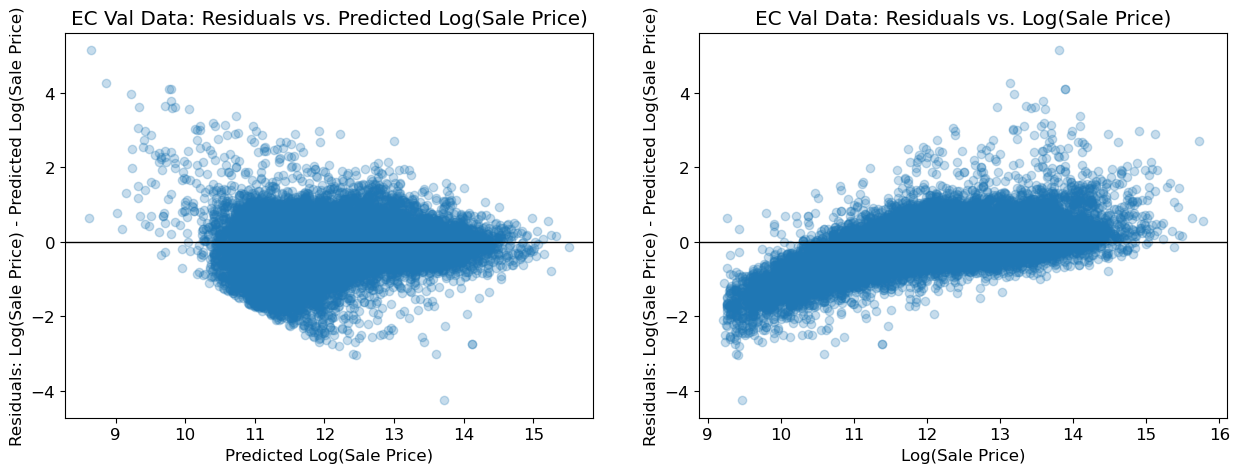

In [46]:
# MODELING STEP 5: Plot 2 side-by-side residual plots for validation data

fig, ax = plt.subplots(1,2, figsize=(15, 5))


x_plt1 = y_predict_valid_ec
y_plt1 = y_valid_ec - y_predict_valid_ec

x_plt2 = y_valid_ec
y_plt2 = y_valid_ec - y_predict_valid_ec

ax[0].scatter(x_plt1, y_plt1, alpha=.25)
ax[0].axhline(0, c='black', linewidth=1)
ax[0].set_xlabel(r'Predicted Log(Sale Price)')
ax[0].set_ylabel(r'Residuals: Log(Sale Price) - Predicted Log(Sale Price)');
ax[0].set_title("EC Val Data: Residuals vs. Predicted Log(Sale Price)")

ax[1].scatter(x_plt2, y_plt2, alpha=.25)
ax[1].axhline(0, c='black', linewidth=1)
ax[1].set_xlabel(r'Log(Sale Price)')
ax[1].set_ylabel(r'Residuals: Log(Sale Price) - Predicted Log(Sale Price)');
ax[1].set_title("EC Val Data: Residuals vs. Log(Sale Price)")

To create my model, I wanted to choose the features that most directly related to log sale price (what we want to predict). Originally, I was just adding parameters onto my model in hopes of improving prediction accuracy. However, because I want to avoid overfitting, I decided to try regularization to determine which features to include in my extra credit model instead of guessing and checking which features were related to log sale price (what I did in Model 3). 

Regularization prevents overfitting by adding a penalty parameter to the MSE that is higher when the model is more complex. We restrict model complexity by placing a penalty on the magnitudes of the model features. Thus, if we increase the penalty parameter, then our model is forced to decrease the magnitudes of less important features and keep the mor important ones to keep MSE low.

I tried regularization by using the Lasso method from scikit-learn introduced in class. Because I knew that I would need to standardize my data to be able to compare all features on the same scale/magnitude, I started by dropping non-numeric columns from the training data (which is what I used to determine my features). Thus, I dropped the description and modeling group columns since I couldn't perform operations on them (like taking the mean) during standardization. Similarly, I also dropped the use and pure market filter columns as the standard deviation of both turned out to be 0 (which I divide by during standardization of the training set). Only after dropping these rows did I standardize the training set.

Next, I imported the Lasso method from scikit-learn. I used Lasso regression to automatically select the best features for predicting log sale price. With Lasso regression, the regularization penalty hyperparameter $\alpha$ controls the complexity of the model. Thus, I tried out a few $\alpha$ values until I had the top 3 most important features. I chose the number 3 because I wanted to build my model using a few important terms, rather than building a model with a lot of features. I found that $\alpha$ values around $0.1$ resulted in a lot of feature, but $\alpha = 0.2$ yielded a coefficient matrix with exactly 3 positive coefficients (with all others being 0/not considered). With $\alpha = 0.2$, I found that building square feet, estimate (building), and latitude were the 3 "best" features for my model, and thus bulid my extra credit model using those three features. 

From the residual graphs of my extra credit model, even though my RMSE was low (below 200k) I still noticed that there was  overestimation of lower prices houses and underestimation of higher prices houses. Thus, my extra credit model is not completely accurate in its predictions, but is better than the models before it. 